# Real world

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.colors import ListedColormap
import time

In [2]:


# Step 1: Load the data from three separate files
def load_class_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            if not line.strip():
                continue
            line_data = line.strip().split()
            if len(line_data) != 2:
                continue  # Skip lines that don't have exactly two values
            try:
                float_data = [float(value) for value in line_data]
                data.append(float_data)
            except ValueError:
                continue  # Skip lines with non-numeric data
    return np.array(data)

# Define file paths for each class
class1_file = "RealWorldDataset\\class1.txt"  # Vowel /o/
class2_file = "RealWorldDataset\\class2.txt"  # Vowel /e/
class3_file = "RealWorldDataset\\class3.txt"  # Vowel /a/

# Check if files exist
for file in [class1_file, class2_file, class3_file]:
    if not os.path.exists(file):
        raise FileNotFoundError(f"Data file '{file}' not found. Please ensure it exists in the directory.")

# Load data for each class
data_class1 = load_class_data(class1_file)
data_class2 = load_class_data(class2_file)
data_class3 = load_class_data(class3_file)

# Assign labels
labels_class1 = np.ones(data_class1.shape[0])
labels_class2 = np.full(data_class2.shape[0], 2)
labels_class3 = np.full(data_class3.shape[0], 3)

# Combine data and labels
X = np.vstack((data_class1, data_class2, data_class3))
y = np.concatenate((labels_class1, labels_class2, labels_class3))

print(f"Total samples: {X.shape[0]}")
print(f"Class 1 (/o/) samples: {data_class1.shape[0]}")
print(f"Class 2 (/e/) samples: {data_class2.shape[0]}")
print(f"Class 3 (/a/) samples: {data_class3.shape[0]}")


Total samples: 7106
Class 1 (/o/) samples: 2488
Class 2 (/e/) samples: 2454
Class 3 (/a/) samples: 2164


In [3]:
def stratified_train_test_split(X, y, test_size=0.3, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    classes = np.unique(y)
    X_train, X_test, y_train, y_test = [], [], [], []
    
    for cls in classes:
        X_cls = X[y == cls]
        y_cls = y[y == cls]
        n_samples = X_cls.shape[0]
        indices = np.random.permutation(n_samples)
        split_idx = int(n_samples * (1 - test_size))
        train_idx, test_idx = indices[:split_idx], indices[split_idx:]
        X_train.append(X_cls[train_idx])
        X_test.append(X_cls[test_idx])
        y_train.append(y_cls[train_idx])
        y_test.append(y_cls[test_idx])
    
    X_train = np.vstack(X_train)
    X_test = np.vstack(X_test)
    y_train = np.concatenate(y_train)
    y_test = np.concatenate(y_test)
    
    train_perm = np.random.permutation(len(y_train))
    test_perm = np.random.permutation(len(y_test))
    return X_train[train_perm], X_test[test_perm], y_train[train_perm], y_test[test_perm]

# Perform stratified split
X_train, X_test, y_train, y_test = stratified_train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Training samples: 4972
Testing samples: 2134


In [4]:
def k_means(X, K, max_iters=100, random_state=42):
    if random_state is not None:
        np.random.seed(random_state)
        
    n_samples, n_features = X.shape
    centroids = X[np.random.choice(n_samples, K, replace=False)]
    for _ in range(max_iters):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        assignments = np.argmin(distances, axis=1)
        new_centroids = np.array([X[assignments == k].mean(axis=0) if len(X[assignments == k]) > 0 else centroids[k] for k in range(K)])
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    return assignments, centroids


In [5]:
def multivariate_gaussian_pdf(X, means, covariances):
    N, D = X.shape  # X should be a 2D array

    # Handle the case where means and covariances are single mean and covariance
    if means.ndim == 1:
        # Single component
        mean = means
        cov = covariances + 1e-6 * np.eye(D)
        diff = X - mean
        inv_cov = np.linalg.inv(cov)
        det_cov = np.linalg.det(cov)
        norm_const = 1.0 / (np.power((2 * np.pi), D / 2) * np.sqrt(det_cov))
        exponent = -0.5 * np.einsum('ij,ij->i', diff @ inv_cov, diff)
        exponent = np.clip(exponent, -500, 500)  # Prevent overflow/underflow
        pdf_values = norm_const * np.exp(exponent)
        return pdf_values
    else:
        # Multiple components
        K = means.shape[0]
        pdfs = np.zeros((N, K))
        
        for k in range(K):
            mean = means[k]
            cov = covariances[k] + 1e-6 * np.eye(D)  # Regularization
            diff = X - mean
            inv_cov = np.linalg.inv(cov)
            det_cov = np.linalg.det(cov)
            norm_const = 1.0 / (np.power((2 * np.pi), D / 2) * np.sqrt(det_cov))
            exponent = -0.5 * np.einsum('ij,ij->i', diff @ inv_cov, diff)
            exponent = np.clip(exponent, -500, 500)  # Prevent overflow/underflow
            pdfs[:, k] = norm_const * np.exp(exponent)
        return pdfs

In [6]:
def gmm_em(X, K, max_iters=100, tol=1e-4, random_state=42):
    if random_state is not None:
        np.random.seed(random_state)

    N, D = X.shape
    K = min(K, N)

    # K-means initialization with given random state
    assignments, means = k_means(X, K, random_state=random_state)

    # Initialize covariances and mixing coefficients
    covariances = []
    for k in range(K):
        if len(X[assignments == k]) > 1:
            cov = np.cov(X[assignments == k].T) + 1e-6 * np.eye(D)  # Regularization
            covariances.append(cov)
        else:
            covariances.append(1e-6 * np.eye(D))  # Small identity if not enough data
    covariances = np.array(covariances)

    mixing_coeffs = np.array([np.mean(assignments == k) for k in range(K)])
    log_likelihoods = []

    for _ in range(max_iters):
        pdfs = multivariate_gaussian_pdf(X, means, covariances)
        responsibilities = mixing_coeffs * pdfs
        sum_responsibilities = np.sum(responsibilities, axis=1, keepdims=True) + 1e-10
        responsibilities /= sum_responsibilities

        N_k = np.sum(responsibilities, axis=0)
        mixing_coeffs = N_k / N
        means = (responsibilities.T @ X) / N_k[:, np.newaxis]
        for k in range(K):
            try:  
                diff = X - means[k]
                weighted_diff = responsibilities[:, k][:, np.newaxis] * diff
                covariances[k] = (weighted_diff.T @ diff) / N_k[k] + 1e-6 * np.eye(D)
            
            except np.linalg.LinAlgError:       # Handle singular matrix
                covariances[k] = 1e-6 * np.eye(D)       # Fall back to small identity matrix if error occurs

        log_likelihood = np.sum(np.log(sum_responsibilities))
        log_likelihoods.append(log_likelihood)
        if len(log_likelihoods) > 1 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    return means, covariances, mixing_coeffs, log_likelihoods


In [7]:
def train_single_gmm(args, random_state=42):
    cls, x_train_cls, K, total_samples = args
    prior = len(x_train_cls) / total_samples  # Calculate prior
    means, covariances, mixing_coeffs, log_likelihoods = gmm_em(x_train_cls, K, random_state=random_state)
    return cls, {
        'means': means,
        'covariances': covariances,
        'mixing_coeffs': mixing_coeffs,
        'prior': prior,
        'log_likelihoods': log_likelihoods  # Store log likelihoods for plotting
    }


In [8]:
def train_gmms(x_train, y_train, K, total_samples, random_state=42):
    classes = np.unique(y_train)
    args = [(cls, x_train[y_train == cls], K, total_samples) for cls in classes]
    
    class_gmm_params = {}
    for arg in args:
        cls, params = train_single_gmm(arg, random_state=random_state)
        class_gmm_params[cls] = params  # Store parameters for the current class
    
    return class_gmm_params


In [9]:
def predict_gmm(X, class_gmm_params):
    classes = list(class_gmm_params.keys())
    N = X.shape[0]
    posteriors = np.zeros((N, len(classes)))

    for idx, cls in enumerate(classes):
        params = class_gmm_params[cls]
        means = params['means']
        covariances = params['covariances']
        mixing_coeffs = params['mixing_coeffs']
        prior = params['prior']
        pdfs = multivariate_gaussian_pdf(X, means, covariances)
        likelihood = np.sum(mixing_coeffs * pdfs, axis=1)
        posteriors[:, idx] = prior * likelihood

    y_pred = np.array([classes[idx] for idx in np.argmax(posteriors, axis=1)])
    return y_pred


In [10]:
def confusion_matrix(y_true, y_pred):
    classes = np.unique(y_true)
    matrix = np.zeros((len(classes), len(classes)), dtype=int)
    for i, true_cls in enumerate(classes):
        for j, pred_cls in enumerate(classes):
            matrix[i, j] = np.sum((y_true == true_cls) & (y_pred == pred_cls))
    return matrix

def compute_metrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    classes = np.unique(y_true)
    acc = np.trace(conf_matrix) / np.sum(conf_matrix)
    precision = np.zeros(len(classes))
    recall = np.zeros(len(classes))
    f1_score = np.zeros(len(classes))
    for idx in range(len(classes)):
        TP = conf_matrix[idx, idx]
        FP = np.sum(conf_matrix[:, idx]) - TP
        FN = np.sum(conf_matrix[idx, :]) - TP
        precision[idx] = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall[idx] = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score[idx] = (2 * precision[idx] * recall[idx]) / (precision[idx] + recall[idx]) if (precision[idx] + recall[idx]) > 0 else 0
    mean_precision = np.mean(precision)
    mean_recall = np.mean(recall)
    mean_f1 = np.mean(f1_score)
    return acc, precision, recall, f1_score, mean_precision, mean_recall, mean_f1


In [11]:
def plot_log_likelihoods(class_gmm_params, K):
    plt.figure(figsize=(10, 6))
    for cls, params in class_gmm_params.items():
        plt.plot(params['log_likelihoods'], label=f'Class {int(cls)}')
    plt.xlabel('Iteration')
    plt.ylabel('Log-Likelihood')
    plt.title(f'Log-Likelihood vs. Iterations for K={K}')
    plt.legend()
    plt.show()


In [12]:
def plot_decision_regions(X_train, y_train, class_gmm_params, resolution=1):
    markers = ('s', 'x', 'o')
    colors = ('red', 'blue', 'green')
    cmap = ListedColormap(colors[:len(np.unique(y_train))])

    x1_min, x1_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    x2_min, x2_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    grid_points = np.c_[xx1.ravel(), xx2.ravel()]
    Z = predict_gmm(grid_points, class_gmm_params)
    Z = Z.reshape(xx1.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cls in enumerate(np.unique(y_train)):
        plt.scatter(x=X_train[y_train == cls, 0],
                    y=X_train[y_train == cls, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {int(cls)}',
                    edgecolor='black')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(loc='upper left')
    plt.title('Decision Region Plot')
    plt.show()

In [13]:
def plot_density_contours(X_train, y_train, class_gmm_params, resolution=100):
    x1_min, x1_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    x2_min, x2_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(
        np.linspace(x1_min, x1_max, resolution),
        np.linspace(x2_min, x2_max, resolution)
    )
    grid_points = np.c_[xx1.ravel(), xx2.ravel()]  # Ensure grid_points is 2D
    plt.figure(figsize=(10, 8))
    
    # Initialize the density matrix
    Z = np.zeros(len(grid_points))
    
    for cls, params in class_gmm_params.items():
        means = params['means']
        covariances = params['covariances']
        mixing_coeffs = params['mixing_coeffs']
        
        # Calculate the probability density function for each component
        for k in range(len(mixing_coeffs)):
            # Compute the PDF for the current component across all grid points
            pdf_values = multivariate_gaussian_pdf(grid_points, means[k], covariances[k])
            # Accumulate weighted probabilities
            Z += mixing_coeffs[k] * pdf_values
    
    Z = Z.reshape(xx1.shape)  # Reshape Z to match the grid shape
    plt.contour(xx1, xx2, Z, levels=5, alpha=0.75, cmap='RdYlBu')
    
    # Plotting the training data points
    markers = ('s', 'x', 'o')
    colors = ('red', 'blue', 'green')
    for idx, cls in enumerate(np.unique(y_train)):
        plt.scatter(x=X_train[y_train == cls, 0],
                    y=X_train[y_train == cls, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {int(cls)}',
                    edgecolor='black')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(loc='upper left')
    plt.title('Density Contour Plot')
    plt.show()



Training GMMs with K=1 components...
Accuracy: 0.9208
Mean Precision: 0.9254
Mean Recall: 0.9222
Mean F1-Score: 0.9233


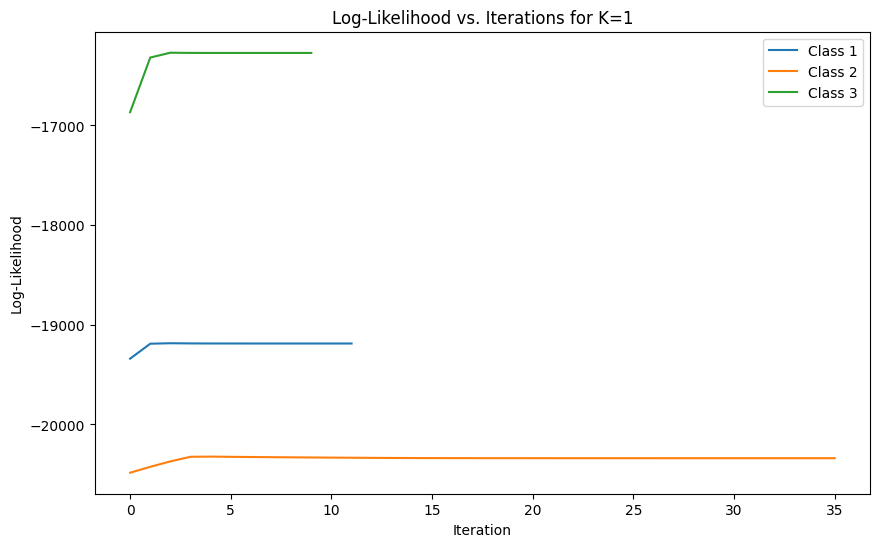


Training GMMs with K=2 components...
Accuracy: 0.9194
Mean Precision: 0.9234
Mean Recall: 0.9208
Mean F1-Score: 0.9219


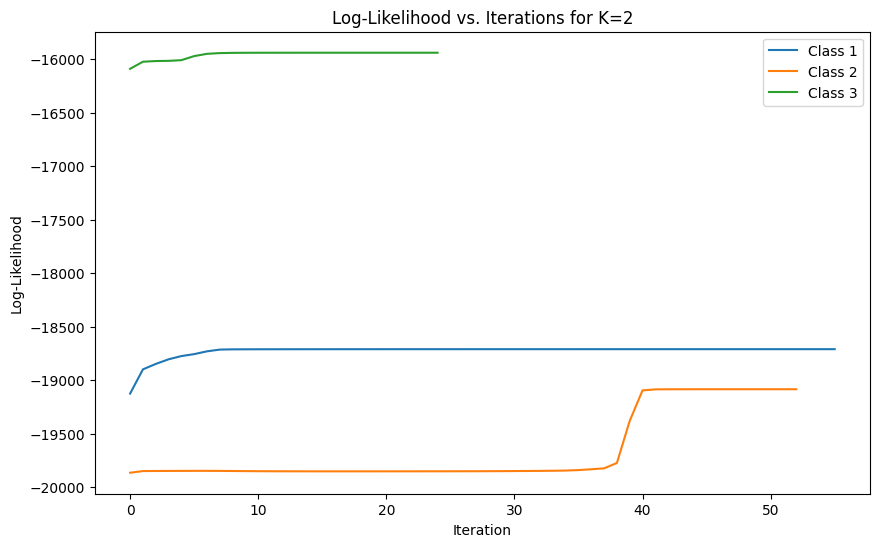


Training GMMs with K=4 components...
Accuracy: 0.9274
Mean Precision: 0.9308
Mean Recall: 0.9290
Mean F1-Score: 0.9298


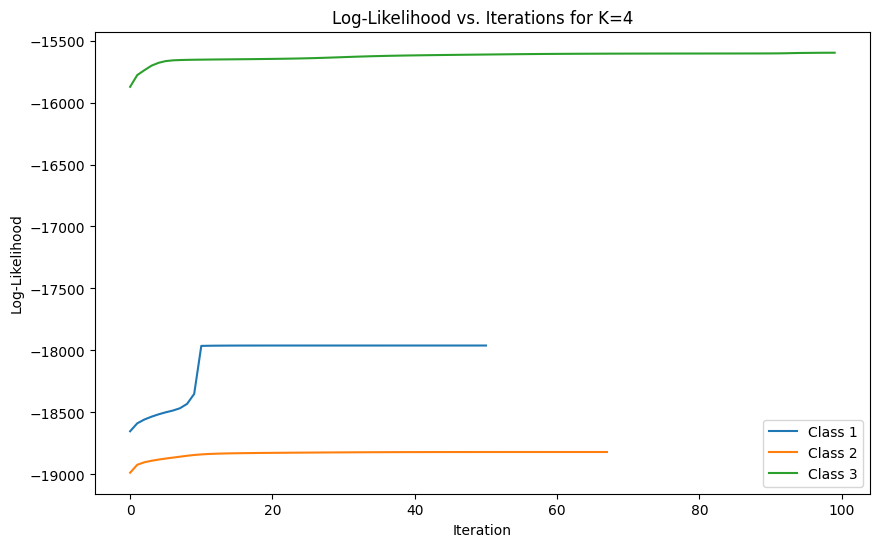


Training GMMs with K=8 components...
Accuracy: 0.9325
Mean Precision: 0.9356
Mean Recall: 0.9339
Mean F1-Score: 0.9345


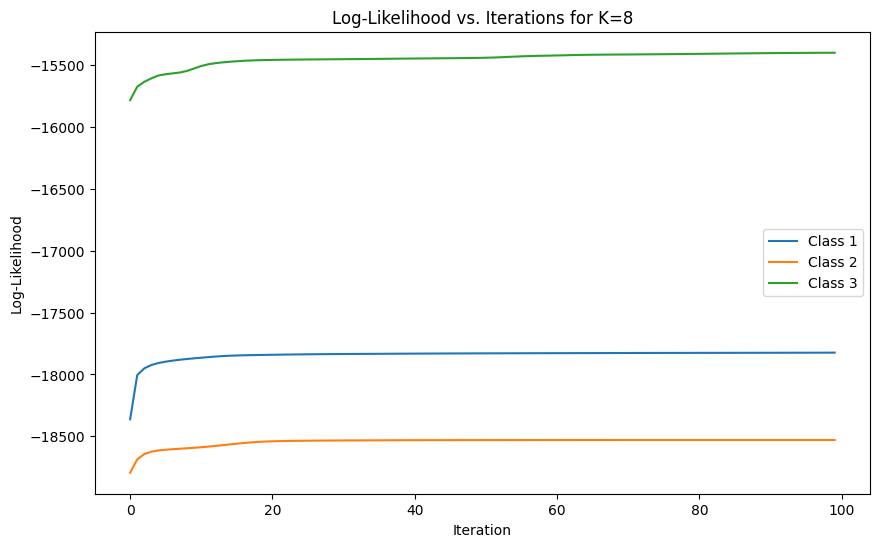


Training GMMs with K=16 components...
Accuracy: 0.9353
Mean Precision: 0.9388
Mean Recall: 0.9366
Mean F1-Score: 0.9374


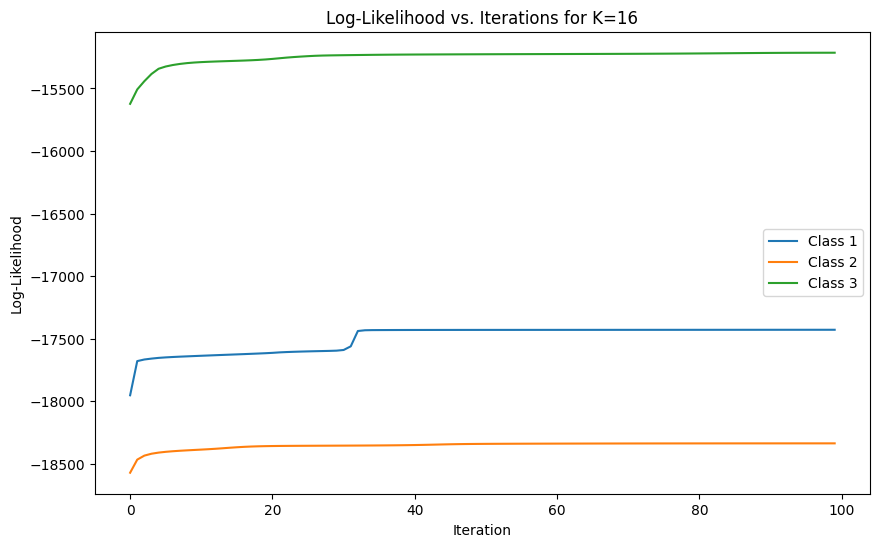


Training GMMs with K=32 components...
Accuracy: 0.9330
Mean Precision: 0.9364
Mean Recall: 0.9342
Mean F1-Score: 0.9351


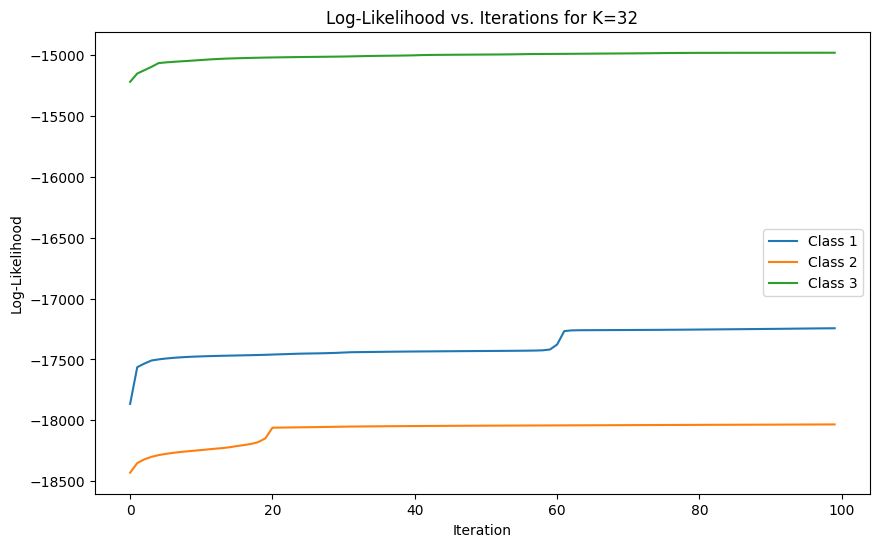


Training GMMs with K=64 components...
Accuracy: 0.9213
Mean Precision: 0.9249
Mean Recall: 0.9227
Mean F1-Score: 0.9236


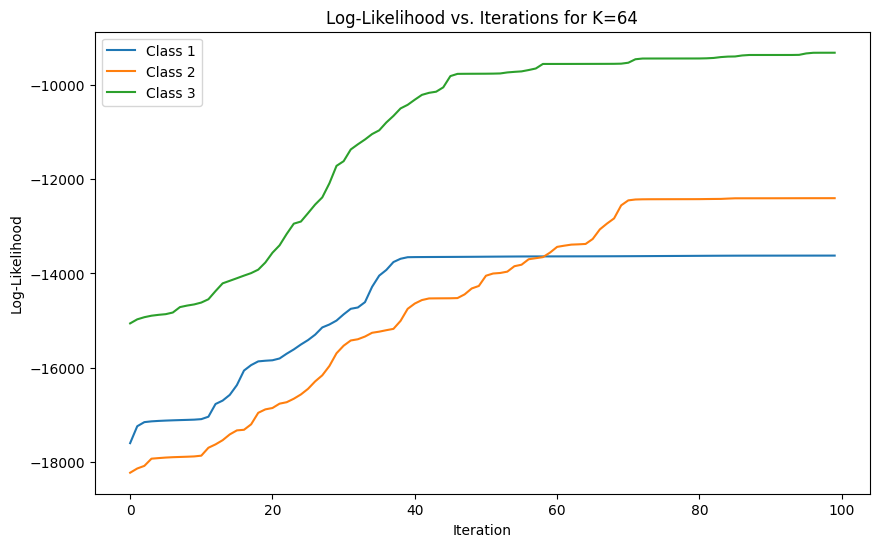

Total time taken for training: 8.99 seconds

Best model has K=16 components with accuracy 0.9353


C:\Users\mridu\AppData\Local\Temp\ipykernel_19268\1140937979.py:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X_train[y_train == cls, 0],


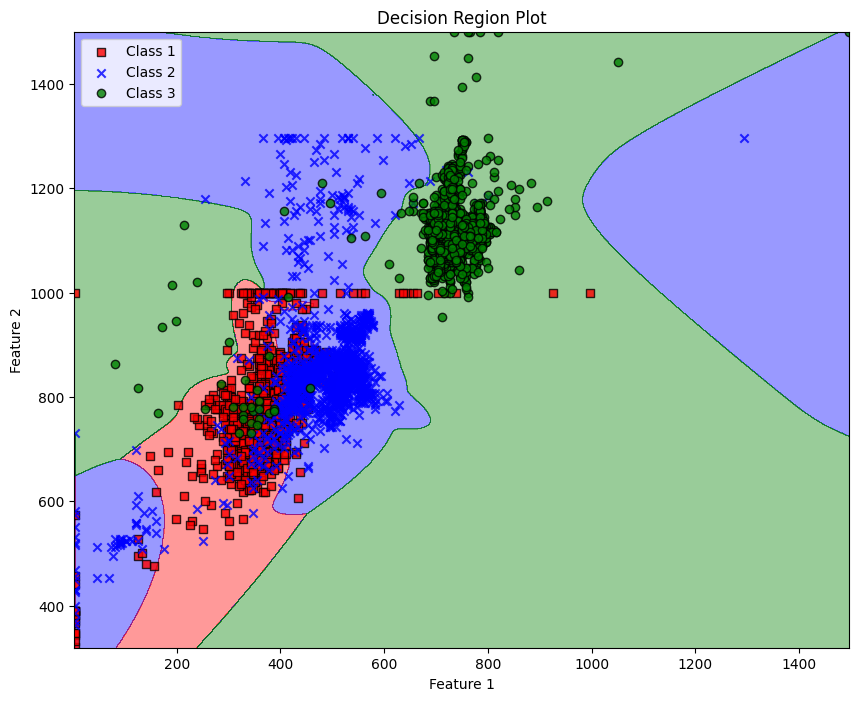

C:\Users\mridu\AppData\Local\Temp\ipykernel_19268\783960843.py:33: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X_train[y_train == cls, 0],


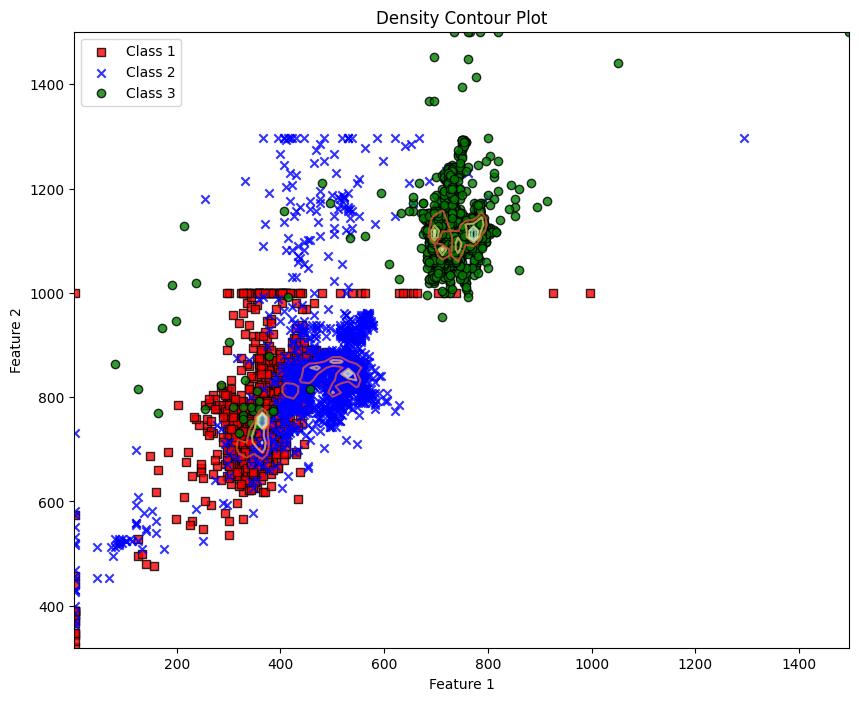


Confusion Matrix for the Best Model (K=16):
[[702  43   2]
 [ 68 665   4]
 [ 16   5 629]]
Accuracy: 0.9353
Precision per class: [0.89312977 0.93267882 0.99055118]
Mean Precision: 0.9388
Recall per class: [0.93975904 0.90230665 0.96769231]
Mean Recall: 0.9366
F1-Score per class: [0.91585127 0.91724138 0.97898833]
Mean F1-Score: 0.9374


In [14]:
# Define the number of components to test
K_values = [1, 2, 4, 8, 16, 32, 64]  # Adjusted for quicker testing

# Initialize a list to store the results
results = []

# Define total_samples for use in GMM training
total_samples = X_train.shape[0]

# Start timing for performance benchmarking
start_time = time.time()

for K in K_values:
    print(f"\nTraining GMMs with K={K} components...")
    class_gmm_params = train_gmms(X_train, y_train, K, total_samples, random_state=42)
    y_pred = predict_gmm(X_test, class_gmm_params)
    acc, precision, recall, f1_score, mean_precision, mean_recall, mean_f1 = compute_metrics(y_test, y_pred)
    results.append({
        'K': K,
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'mean_precision': mean_precision,
        'mean_recall': mean_recall,
        'mean_f1': mean_f1
    })
    print(f"Accuracy: {acc:.4f}")
    print(f"Mean Precision: {mean_precision:.4f}")
    print(f"Mean Recall: {mean_recall:.4f}")
    print(f"Mean F1-Score: {mean_f1:.4f}")

    # Plot log-likelihoods
    plot_log_likelihoods(class_gmm_params, K)

# End timing for performance benchmarking
end_time = time.time()
print(f"Total time taken for training: {end_time - start_time:.2f} seconds")

# Find the best model based on accuracy
best_result = max(results, key=lambda x: x['accuracy'])
best_K = best_result['K']
print(f"\nBest model has K={best_K} components with accuracy {best_result['accuracy']:.4f}")

# Retrain the best model to generate plots
class_gmm_params = train_gmms(X_train, y_train, best_K, total_samples)

# Generate the required plots
plot_decision_regions(X_train, y_train, class_gmm_params)
plot_density_contours(X_train, y_train, class_gmm_params)

# Predict on test data using the best model
y_pred = predict_gmm(X_test, class_gmm_params)
# Compute confusion matrix and metrics
conf_matrix = confusion_matrix(y_test, y_pred)
acc, precision, recall, f1_score, mean_precision, mean_recall, mean_f1 = compute_metrics(y_test, y_pred)

# Print confusion matrix and metrics
print(f"\nConfusion Matrix for the Best Model (K={best_K}):\n{conf_matrix}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision per class: {precision}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Recall per class: {recall}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"F1-Score per class: {f1_score}")
print(f"Mean F1-Score: {mean_f1:.4f}")


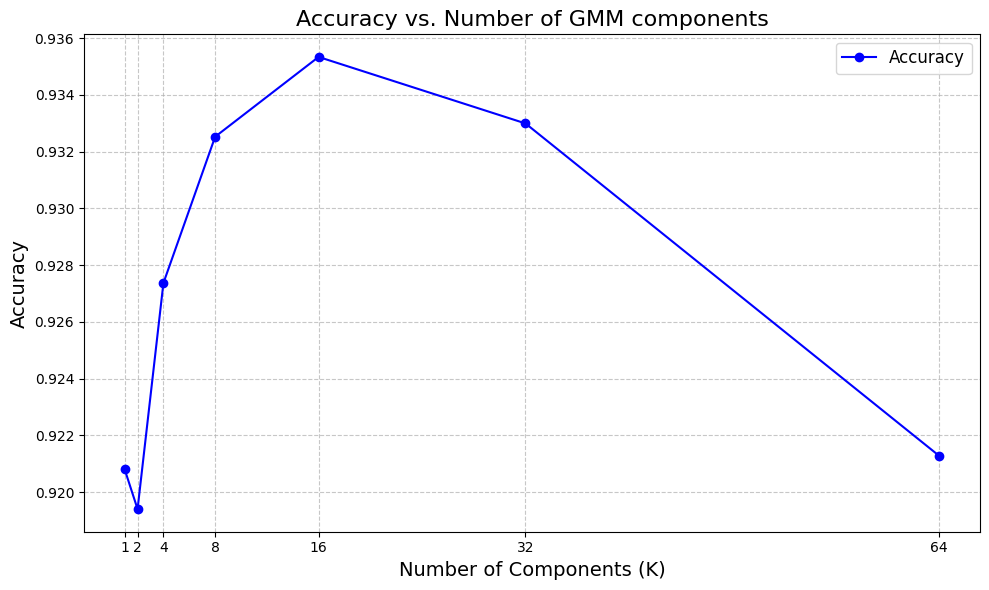

In [15]:
sorted_results = sorted(results, key=lambda x: x['K'])

K_list = [result['K'] for result in sorted_results]
accuracy_list = [result['accuracy'] for result in sorted_results]

plt.figure(figsize=(10,6))
plt.plot(K_list, accuracy_list, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Number of Components (K)', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy vs. Number of GMM components', fontsize=16)
plt.xticks(K_list)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

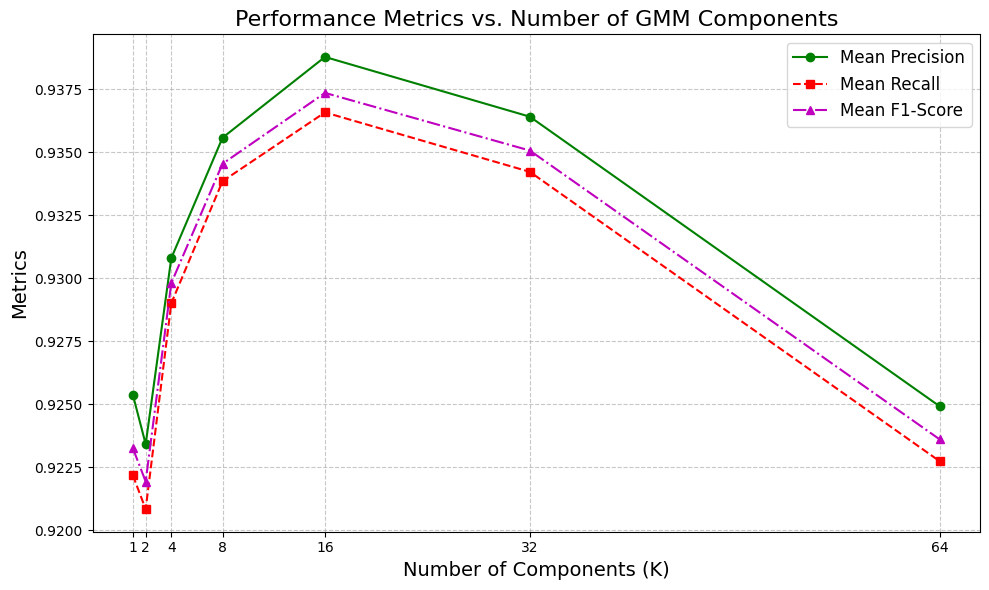

In [16]:
# Sort results by K to ensure ordered plotting
sorted_results = sorted(results, key=lambda x: x['K'])
    
K_list = [result['K'] for result in sorted_results]
mean_precision_list = [result['mean_precision'] for result in sorted_results]
mean_recall_list = [result['mean_recall'] for result in sorted_results]
mean_f1_list = [result['mean_f1'] for result in sorted_results]
    
plt.figure(figsize=(10, 6))
plt.plot(K_list, mean_precision_list, marker='o', linestyle='-', label='Mean Precision', color='g')
plt.plot(K_list, mean_recall_list, marker='s', linestyle='--', label='Mean Recall', color='r')
plt.plot(K_list, mean_f1_list, marker='^', linestyle='-.', label='Mean F1-Score', color='m')
plt.xlabel('Number of Components (K)', fontsize=14)
plt.ylabel('Metrics', fontsize=14)
plt.title('Performance Metrics vs. Number of GMM Components', fontsize=16)
plt.xticks(K_list)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
